## Travel time based reprojection of a network
This started out as the notebook developed by [Geoff Boeing](https://geoffboeing.com/) available [here](https://github.com/gboeing/osmnx-examples/blob/master/notebooks/13-isolines-isochrones.ipynb) although by now it has been very heavily modified! 

I was lucky enough to co-advise Geoff as a PhD student at Berkeley, and when he announced that he was going to build [`osmnx`](https://github.com/gboeing/osmnx) as _part_ of his project&mdash;only a part, mind!&mdash;I did the proper thing and expressed concern that he was being overly ambitious. PhD advising is mostly about steering students towards the possible, and reining in their wilder ideas... at least that is the common wisdom. So much for that: Geoff built it and the rest is (niche) history. 

[If I have one criticism of `osmnx` it is that the code gets updated so often that function names are subject to rapid change. You may find that some of what follows doesn't work in more recent versions than 1.6.0.]

Anyway... as usual we need some libraries:

In [68]:
import math
import pandas
import geopandas
import matplotlib.pyplot as plt
import networkx
import igraph
import osmnx
from shapely.geometry import Point

osmnx.settings.log_console = True
osmnx.settings.use_cache = True

## Download and prep the street network
What `osmnx` excels at is pulling (generally messy) street network data and cleaning it up for analysis. Here's how it works:

In [69]:
#| warning: false

# configure the place, network type, trip times, and travel speed
place = "Santa Barbara, California"
network_type = "drive"

G = osmnx.graph_from_place(place, network_type = network_type)

/Users/osullid3/miniconda3/envs/cg/lib/python3.11/site-packages/shapely/constructive.py:181: RuntimeWarning: invalid value encountered in buffer
  return lib.buffer(
/Users/osullid3/miniconda3/envs/cg/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/osullid3/miniconda3/envs/cg/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)
/Users/osullid3/miniconda3/envs/cg/lib/python3.11/site-packages/shapely/predicates.py:798: RuntimeWarning: invalid value encountered in intersects
  return lib.intersects(a, b, **kwargs)
/Users/osullid3/miniconda3/envs/cg/lib/python3.11/site-packages/shapely/set_operations.py:340: RuntimeWarning: invalid value encountered in union
  return lib.union(a, b, **kwargs)


The network needs to be connected for any of the following to work reliably, so we extract the largest component and throw away everything else. I can't vouch for this being the best way to accomplish this, but it seems to work.

In [70]:
G = G.to_undirected() # required for extraction of giant component

Gcc = sorted(networkx.connected_components(G), key = len, reverse = True)
G = G.subgraph(Gcc[0]).copy()

### Some geography stuff...
This line will project the data to an appropriate UTM projection, and then we can make an appropriately UTM projected `geopandas.GeoDataFrame`.

In [71]:
G = osmnx.project_graph(G)
gdf_nodes = osmnx.graph_to_gdfs(G, edges = False)
CRS = gdf_nodes.crs

Next we make a [*convex hull*](https://en.wikipedia.org/wiki/Convex_hull) of the nodes, and determine its centroid, then use this to find the node nearest the centroid. We also make a simple `GeoSeries` so we can check what we've done makes sense.

In [72]:
convex_hull = gdf_nodes["geometry"].unary_union.convex_hull
x, y = convex_hull.centroid.xy
centre_node = osmnx.distance.nearest_nodes(G, x[0], y[0])
p1 = geopandas.GeoSeries([Point(x[0], y[0])])
p2 = geopandas.GeoSeries(Point(G.nodes[centre_node]["x"],
                               G.nodes[centre_node]["y"]))

And we can make a sanity check plot

<Axes: >

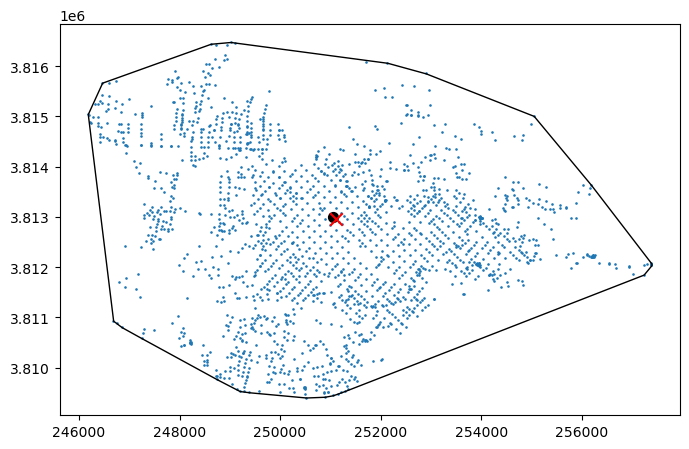

In [73]:
ax = gdf_nodes.plot(markersize = 0.75, figsize = (8, 16))

geopandas.GeoSeries([convex_hull]).plot(ax = ax, fc = "#00000000", ec = "k")
p1.plot(ax = ax, marker = "o", markersize = 50, color = "k")
p2.plot(ax = ax, marker = "x", markersize = 80, color = "r")

## Handling the edge travel times
The data in OSM networks is fairly *ad hoc* in this regard, so the below has been assembled by trial and error. There may be better tools available for cleaning up network data attributes.

We assume a `default_speed` of 30 km/h expressed in metres per minute (i.e. 500!). Where we find maximum speed information in the data we use that instead.

We assume a delay at intersections&mdash;this might not make total sense, but slows things down on major arterials.

`speed_units_per_metre` is the maxspeed attribute from OSM and for most jurisdictions is km, so 0.001 per metre.

In [74]:
default_speed = 30 * 1000 / 60 # default driving speed in m / min
intersection_delay = .33 # wait time at intersection in minutes
units_per_metre = 0.001

Some hackery below to convert appropriately if `maxspeed` is missing or is a list of some kind or is expressed in mph.

In [75]:
# add an edge attribute for time in minutes required to traverse each edge
for data in G.edges.values():
    len_seg = data["length"]
    data["time"] = len_seg / default_speed
    if "maxspeed" in data:
        max_speed = data["maxspeed"]
        if type(max_speed) is list:
            max_speed = max_speed[0]
        if ";" in max_speed:
            max_speed = max_speed.split(";")[0]
        if "mph" in max_speed:
            max_speed = max_speed.split()[0]
            units_per_metre = 0.0006213712
        if max_speed.isnumeric():
            max_speed = float(max_speed)
        data["time"] = len_seg * units_per_metre / max_speed * 60
    data["time"] += intersection_delay

### Calculate node distances from centre node
Now we can determine network travel times from our centre node to every other node. While assembling this notebook I encountered a problem with the `networkx` function `single_source_path_length()` function, which can be unreliable with floating point edge weights (in this cast the `time` attribute). As a workaround I am using `igraph` instead. 

In [76]:
centre_node_index = [n for n in G.nodes].index(centre_node)
iG = igraph.Graph.from_networkx(G)
iG.vs[centre_node_index]

node_travel_times = dict(zip(
  G.nodes, 
  iG.distances([centre_node_index], weights = "time", mode = "all")[0]))

We also need the bearings of every node from the centre node.

In [77]:
# Assume that nodes have x and y attributes and these are in a projected
# coordinate system such that simple trigonometry will give bearing
def bearing(G, n0, n1):
    N0 = G.nodes[n0]
    N1 = G.nodes[n1]
    return n1, \
        math.atan2((N1["y"] - N0["y"]), (N1["x"] - N0["x"]))
                 
node_bearings = dict(
  [bearing(G, centre_node, n) for n in node_travel_times.keys()])

and... a function to return $x$ and $y$ offsets from the centre node, given their distance and bearing.

In [78]:
def dxdy(d, b):
    return d * math.cos(b), d * math.sin(b)

### Dictionary of x y offsets from centre node indexed by node
Keep in mind distances are now travel time based, while bearings remain 'true', so that less accessible locations are pushed farther from centre, and more accessible ones pulled nearer in the direction of the bearting. Note that all angles here are in radians.

In [79]:
node_dxdys = dict(
  [(n, dxdy(node_travel_times[n], node_bearings[n])) 
   for n in node_travel_times.keys()])

### Put all this in a table for safe keeping!

In [80]:
import pandas
df_nodes = pandas.DataFrame(data = {"osmid": list(node_travel_times.keys())})

df_nodes["tx"] = [node_dxdys[i][0] for i in df_nodes.osmid]
df_nodes["ty"] = [node_dxdys[i][1] for i in df_nodes.osmid]
df_nodes["x"] = [G.nodes[i]["x"] for i in df_nodes.osmid]
df_nodes["y"] = [G.nodes[i]["y"] for i in df_nodes.osmid]
df_nodes["time"] = [node_travel_times[i] for i in df_nodes.osmid]

df_nodes.head()

,osmid,tx,ty,x,y,time
0,164707756,-10.095840,0.516131,248112.235570,3.813112e+06,10.109025
1,164707812,-10.891007,-0.676010,247856.180584,3.812756e+06,10.911967
2,165442802,-10.533059,0.734952,248000.588151,3.813176e+06,10.558668
3,1467958591,-9.136781,-0.608773,248676.344687,3.812796e+06,9.157039
4,165337776,-11.392333,-0.672562,247771.128942,3.812761e+06,11.412169


Write this out to disk and read it back in. This means you can start here next time if you prefer...

In [81]:
#| eval: false

df_nodes.to_csv("nodes.csv", index = False)
df_nodes = pandas.read_csv("nodes.csv")

## Now make `GeoDataFrame`s and maps
This is pretty simple now we have all the data.

In [82]:
n_gdf_xy = geopandas.GeoDataFrame(
  data = df_nodes[["time"]], 
  geometry = geopandas.GeoSeries(
    [Point(p[0], p[1]) for p in zip(df_nodes.x, df_nodes.y)]))
n_gdf_xy.set_crs(CRS)

n_gdf_txty = geopandas.GeoDataFrame(
  data = df_nodes[["time"]],
  geometry = geopandas.GeoSeries(
    [Point(p[0], p[1]) for p in zip(df_nodes.tx, df_nodes.ty)]))


And make two maps of the nodes.

Text(0.5, 1.0, 'Santa Barbara in drivetime space')

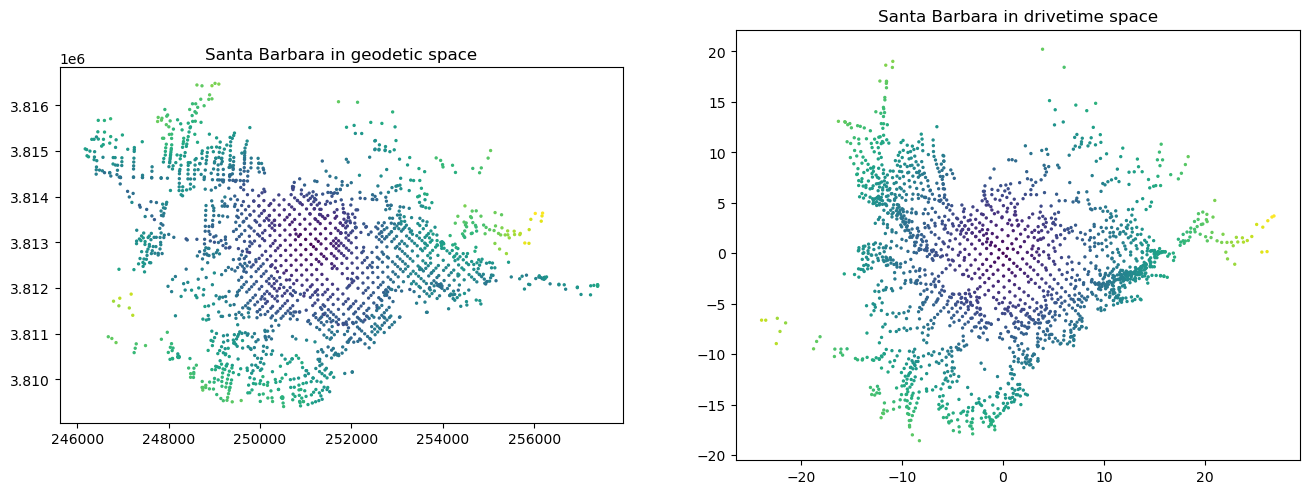

In [83]:
fig = plt.figure(figsize = (16, 8))

ax = fig.add_subplot(121)
n_gdf_xy.plot(ax = ax, column = "time", markersize = 2)
ax.set_title("Santa Barbara in geodetic space")

ax = fig.add_subplot(122)
n_gdf_txty.plot(ax = ax, column = "time", markersize = 2)
ax.set_title("Santa Barbara in drivetime space")


## Plots that include the edges
### Standard map
The geodetic one is easy&mdash;just use the `osmnx` plotting function

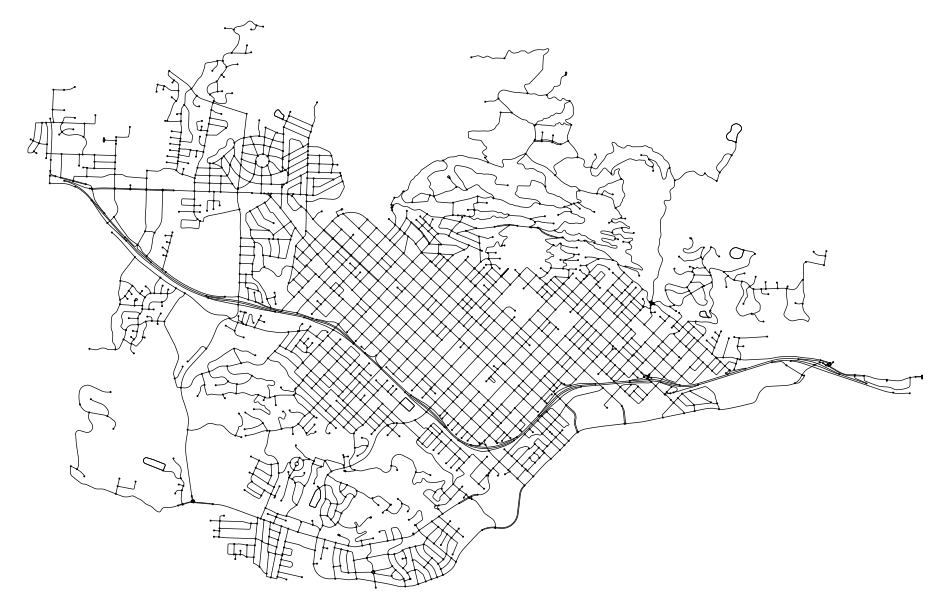

(<Figure size 1200x800 with 1 Axes>, <Axes: >)

In [84]:
osmnx.plot_graph(G, node_color = "k", node_size = 2, figsize = (12, 8),
                           edge_color = "k", edge_linewidth = 0.5, 
                           bgcolor = "w")

### Time based is trickier...
First we need to make a new graph with the time based positions as the node positions

In [85]:
G_time = G.copy()

for n, dxdy in node_dxdys.items():
    G_time.nodes()[n]["x"] = dxdy[0]
    G_time.nodes()[n]["y"] = dxdy[1]

Now... for reasons unclear to me, simply plotting this using `osmnx` will not work&mdash;presumably (yet again!) something to do with projections. Instead we need to make a `matplotlib` `LineCollection` and plot that... so here goes...

(-24.923310674353207,
 27.844793379718062,
 -19.572596660049093,
 21.215954647646313)

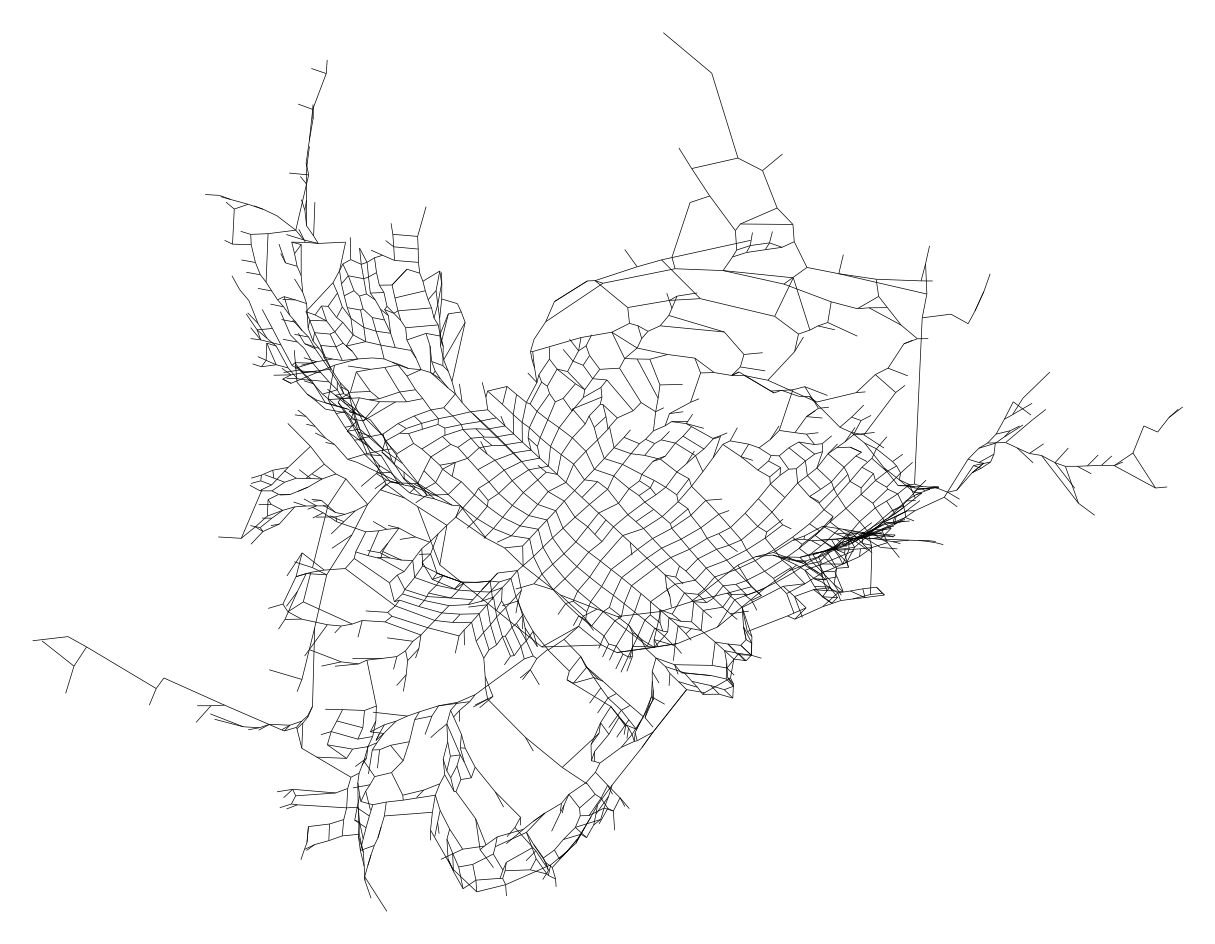

In [86]:
# define the plot limits
node_xs = [float(n["x"]) for n in G_time.nodes.values()]
node_ys = [float(n["y"]) for n in G_time.nodes.values()]

W, S, E, N = (min(node_xs) - 1, min(node_ys) - 1,
              max(node_xs) + 1, max(node_ys) + 1)
bbox_aspect = (N - S) / (E - W)
fig_h = 12
fig_w = 12 / bbox_aspect

# create the figure and axis
fig, ax = plt.subplots(figsize = (fig_w, fig_h))
ax.set_xlim(W, E)
ax.set_ylim(S, N)
ax.set_aspect("equal")

lines = []
for u, v, data in G_time.edges.keys():
    lines.append([(G_time.nodes[u]["x"], G_time.nodes[u]["y"]),
                  (G_time.nodes[v]["x"], G_time.nodes[v]["y"])])

from matplotlib.collections import LineCollection
ax.add_collection(LineCollection(lines, colors = "k", linewidth = .5))
plt.axis("off")